# Safe Absorbing States

In [1]:
from NN import *
from LTL import *
from Utility_funcs import *

%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time
import os


Number of Omega-automaton states (including the trap state): 4


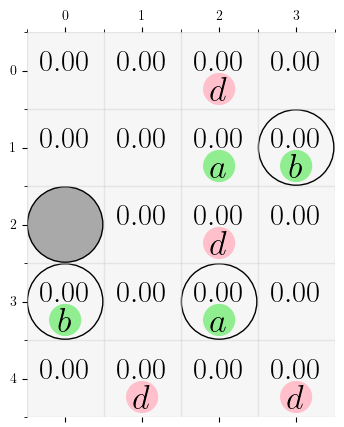

In [2]:
# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('d',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('d',),()],
[('b',),   (),     ('a',),()],
[(),       ('d',), (),    ('d',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)

In [3]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)
predicates

{'a': [6, 14], 'b': [7, 12], 'd': [2, 10, 17, 19]}

In [4]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [5]:
model(ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [6]:
# model.load_weights(f'first_case_{p}')

In [7]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 10
MCTS_samples = 100

num_training_epochs =  20
num_test_epochs = 20
training = True
epochs = 10
T = [25, 50, 75, 100, 200, 400]
LTL_coefs = [100, 10, 1]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

os.remove("Log_run.txt")
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
for i in T:
    # C = Cs[idx % 5]
    # LTL_coef = LTL_coefs[idx]
    # print(C)
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,0,0)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.1, tow=0.7, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False, LTL_coef=LTL_coef)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.1, tow=0.7, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

[0. 0. 0. 0.] 0
0 ) MCTS conf: 0.69 , det: 0.92 | LTL [+++]  LDBA [ 0.23 ] path: [11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[0. 0. 0. 0.] 8
1 ) MCTS conf: 0.9 , det: 0.97 | LTL [+++]  LDBA [ 0.23 ] path: [11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[0. 0. 0. 0.] 8
2 ) MCTS conf: -0.08 , det: 0.87 | LTL [---]  LDBA [ 0.0 ] path: [9, 5, 1, 0, 0, 1, 5, 9, 13, 9, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[-0.3 -0.3 -0.3 -0.3] 36
3 ) MCTS conf: 0.8 , det: 0.5 | LTL [+++]  LDBA [ 0.22 ] path: [5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[-0.3 -0.3 -0.3 -0.3] 36
4 ) MCTS conf: 0.8 , det: 0.71 | LTL [---]  LDBA [ 0.0 ] path: [5, 1, 1, 1, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.3 -0.3 -0.3 -0.3] 36
5 ) MCTS conf: 0.7 , det: 0.96 | LTL [+++]  LDBA [ 0.21 ] path: [9, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[-0.3 -0.3 -0.3 -0.

KeyboardInterrupt: 

In [8]:
# model.save_weights(filepath=f'first_case_{p}')

[100.0]

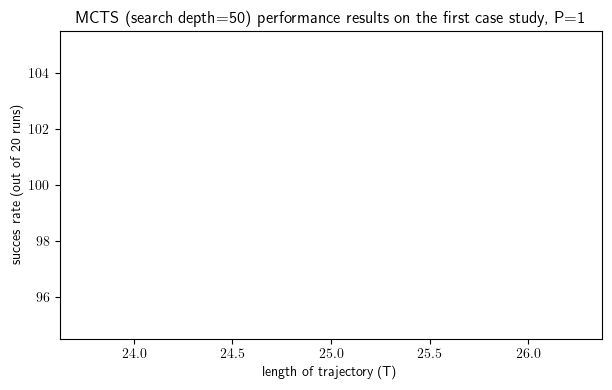

In [9]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

In [10]:
Q=csrl.q_learning(T=100,K=100000)
np.save(f'Q1_{p}', Q)

KeyboardInterrupt: 

In [ ]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [ ]:
rewards_mean = []
rewards_std = []
n_runs = 200

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=None, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
# plt.title("Comparison on the first case; stochastic")
plt.title("Comparison on the first case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C1_P{p}.pdf")

In [ ]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))